## Import necessary python modules

In [1]:
import os
import napari
import tifffile
import numpy as np
import matplotlib.pyplot as plt

import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ, reorderZstack, getSpotAndClusters_multi

## Specify Input and Output folders, identifiers

In [2]:
homeFolder = '/media/raphael/data/works/full_data_movie/'
nameKey = 'c3_21_c3_45_ON_1_w1SPI-488_s'

imsQ = '3'
cellNumber = '23'
nucleiStackForm = nameKey+imsQ+"_cell_"

pathToTimeSequenceFullView = homeFolder+nameKey+imsQ+'/*.tif'
cell_Crop_Folder = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
pathToTimeSequenceCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'


sequenceCell = imr(pathToTimeSequenceCell)
sequenceCell = sequenceCell
mipSequenceCell = np.max(sequenceCell, axis=1)
MaxTimePoint = sequenceCell.shape[0]

## Specify voxel and object size

In [3]:
voxelRadius = (700, 110, 110) # in nanometers
objectRadius = (700, 105, 105) # in nanometers

In [4]:
# Save Maximum Intensity Projection of the cell movie

maxProjSavePath = homeFolder+nameKey+imsQ+'/'
with tifffile.TiffWriter(maxProjSavePath+'MAX_cell'+cellNumber+'.tif', imagej=True) as tif:
    tif.write(mipSequenceCell)

## Choose detection threshold

In [5]:
selectedThreshold = int(input("Enter your selected threshold: "))

Enter your selected threshold: 250


In [6]:
minFrame = int(input("Enter your max Frame: "))
minFrame = minFrame 

Enter your max Frame: 1


In [7]:
maxFrame = int(input("Enter your max Frame: "))
maxFrame = maxFrame + 1 

Enter your max Frame: 123


### Compute list of threshold 

## Get a list of spots detected using the threshold specified in previous step

Voire graphe du notebook 4 bleaching correction

Toutes les frames ne suivent pas la meme allure avec des images bcp moins intense que l'autre d'une frame a l'autre besoin de ponderer le threshold en fonction d'une moyenne generale et d'une liste de moyenne en fonction des frames 

if mean_frame < moy_gen :
    abaisser le threshold
elid mean_frame > moy_gen :
    augmenter le threshold
    
else : 
    conserver threshold 
    
Ou possibilite d'appliquer ce principe a une difference de pourcentage d'une frame a l'autre 

In [8]:
images=[]    
spots_list=[]

spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=voxelRadius, 
    object_radius_nm=objectRadius, 
    ndim=3)

for t in range(minFrame,maxFrame,1):

    path = os.path.join(cell_Crop_Folder, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)
    images.append(rna)

n=len(images)
print("Total number of images : "+str(n))

selectedThreshold_loop = selectedThreshold

for rna in images:
    try : 
        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)
    
        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)
    
        # thresholding
        threshold = detection.automated_threshold_setting(rna_log, mask)
        
        selectedThreshold_loop = (selectedThreshold_loop) #*((100+var_list[i])/100) 
        #print(selectedThreshold_loop)
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold_loop))
        spots_list.append(spots_)
    except IndexError as e: 
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
        spots_list.append(spots_)
        print('Done')
        break 

Total number of images : 123


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


## Build reference spot

image list found!
Found 2924
Found 2924 spots, max intensity = 775


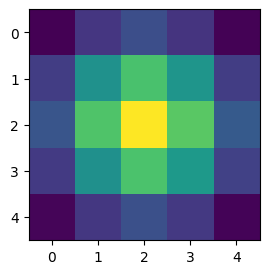

In [9]:
reference_spot = buildReferenceSpotFromImages(images[:20], spots_list, alpha=0.5, gamma=5, voxelSize=voxelRadius, objectSize=objectRadius)
%matplotlib inline
plt.figure(num=3,figsize=(3,3))
plt.imshow(np.max(reference_spot, axis=0))
refSpot = deepcopy(reference_spot)

## Perform spot and cluster detection for all frames

In [205]:
spotsFrame, clustersFrames, ThresholdFrames = getSpotAndClusters_multi(cell_Crop_Folder, 
                                                                 reference_spot, 
                                                                 [1],
                                                                 cellnumber=cellNumber, 
                                                                 startTime=minFrame,
                                                                 stopTime=maxFrame,
                                                                 thresholdManual=selectedThreshold, 
                                                                 beta=1, 
                                                                 gamma=10,
                                                                 numberOfSpots=2,
                                                                 radiusCluster=400, 
                                                                 voxelSize=voxelRadius, 
                                                                 objectSize=objectRadius,
                                                                 extensionMov='.tif')

part movie 123
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
old factor :  1
done!


In [142]:
from alive_progress import alive_bar
import time
def order_clusters_frames(clustersFrames,mipSequenceCell,threshold ):

    res = []
    with alive_bar(len(clustersFrames), title = "order cluster frame",force_tty=True) as bar :
        for i in range(len(clustersFrames)):
            #print('clustersFrames', i)
            frame = clustersFrames[i]
            tmp =[]
            id = 0
            for j in range(len(frame)):
                y_coord = frame[j][1]
                x_coord = frame[j][2]

                test = np.array(mipSequenceCell[i][y_coord:y_coord+1,x_coord:x_coord+1])
                val = test[0][0]
                if val < threshold : 
                    print(i,val)
                tmp.append(val)

            try :
                # possibilite de rajouter une condition 
                # pour filtrer les sites de transcription uniquement en rajoutant un threshold de 1000
                if max(tmp) < threshold :
                    res.append([np.zeros(5)])
                else :
                    index_max = tmp.index(max(tmp))
                    #print(max(tmp), index_max)
                    #print(frame)
                    res.append([frame[index_max]])

            except ValueError as e:
                res.append([np.zeros(5)])
            time.sleep(0.1)
            bar()
        
    
        return res 
    

In [85]:
import statistics
def get_large_clusters_v2(clustersFrames,mipSequenceCell,threshold,diff=2):
    res=[]
    
    for i in range(0,len(clustersFrames)):
        frame = clustersFrames[i]
        tmp=[]
        index_spt = []
        for j in range(len(frame)):
            y_coord = frame[j][1]
            x_coord = frame[j][2]
            nb_mol = frame[j][3]
            
            # get value of most intenses pixels in MIP
            test = np.array(mipSequenceCell[i][y_coord:y_coord+1, x_coord:x_coord+1])
            val = test[0][0]
            tmp.append(val) 
            
        if max(tmp)<threshold:
            res.append([np.zeros(5)])
        else : 
            for thres in tmp : 
                if thres > threshold : 
                    index_spt.append(tmp.index(thres)) # recupere l'index des pixels superieur au threshold 
            # fusion des clusters 
            tmp_y = []
            tmp_x = []
            tmp_m = []
            for k in range(0,len(index_spt)-1) :

                ind = index_spt[k]
                ind1 = index_spt[k+1]

                f1 = frame[ind]
                f2 = frame[ind1]

                print(i, f1,f2)
                if 0 <= f1[1] - f2[1] <= 2 and 0 <= f1[2] - f2[2] <= 2 : 
                    tmp_y.append(f1[1])
                    tmp_y.append(f2[1])
                    
                    tmp_x.append(f1[2])
                    tmp_x.append(f2[2])
                    
                    tmp_m.append(f1[3])
                    tmp_m.append(f2[3])
                    

            if tmp_y != [] and tmp_x != [] and tmp_m != [] : 
                print(tmp_x)
                res.append([0,statistics.mean(tmp_y),statistics.mean(tmp_x),statistics.mean(tmp_m),0])
            else : 
                res.append(f1)

    return res 


a = get_large_clusters_v2(clustersFrames,mipSequenceCell,530)

0 [31 43 53 13  0] [31 43 53 13  0]
0 [31 43 53 13  0] [33 69 64  2  2]
[53, 53]
1 [28 38 67 13  0] [28 28 69  2  1]
1 [28 28 69  2  1] [ 32  40 131   2   2]
1 [ 32  40 131   2   2] [29 77 83  2  3]
1 [29 77 83  2  3] [ 32  42 123   2   4]
1 [ 32  42 123   2   4] [ 32  50 135   2   5]
1 [ 32  50 135   2   5] [27 25 84  2  6]
1 [27 25 84  2  6] [28 82 79  2  7]
2 [ 0 66 92  2  0] [ 0 68 62  4  1]
2 [ 0 68 62  4  1] [ 0 39 71  2  2]
2 [ 0 39 71  2  2] [ 0 64 71  2  3]
2 [ 0 64 71  2  3] [ 0 76 63  2  4]
2 [ 0 76 63  2  4] [ 0 75 71  2  5]
2 [ 0 75 71  2  5] [31 26 74  6  6]
2 [31 26 74  6  6] [32 26 72  5  7]
2 [32 26 72  5  7] [34 36 75  2  8]
2 [34 36 75  2  8] [35 42 83  3  9]
2 [35 42 83  3  9] [32 31 74  2 10]
2 [32 31 74  2 10] [ 35  68 110   2  11]
2 [ 35  68 110   2  11] [ 35  35 110   2  12]
[74, 72]
3 [27 41 83  8  0] [30 63 61  2  1]
3 [30 63 61  2  1] [32 64 61  2  2]
3 [32 64 61  2  2] [32 26 69  2  3]
3 [32 26 69  2  3] [32 64 56  2  4]
3 [32 64 56  2  4] [29 54 64  2  5]
3

21 [ 20  57 108   2   0] [ 21  49 104   2   1]
21 [ 21  49 104   2   1] [ 22  59 108   2   2]
21 [ 22  59 108   2   2] [20 68 94  2  3]
21 [20 68 94  2  3] [27 89 93  7  4]
21 [27 89 93  7  4] [ 31  48 108   3   5]
21 [ 31  48 108   3   5] [30 29 83  3  6]
21 [30 29 83  3  6] [ 31  41 109   2   7]
21 [ 31  41 109   2   7] [31 47 68  3  8]
21 [31 47 68  3  8] [28 68 67  3  9]
21 [28 68 67  3  9] [31 57 77  2 10]
21 [31 57 77  2 10] [31 36 75  2 11]
21 [31 36 75  2 11] [32 40 91  2 12]
21 [32 40 91  2 12] [27 30 84  2 13]
21 [27 30 84  2 13] [29 26 86  2 14]
21 [29 26 86  2 14] [29 80 79  3 15]
21 [29 80 79  3 15] [27 74 71  2 16]
21 [27 74 71  2 16] [31 58 95  2 17]
21 [31 58 95  2 17] [29 64 66  2 18]
21 [29 64 66  2 18] [32 45 74  2 19]
21 [32 45 74  2 19] [25 98 98  2 20]
21 [25 98 98  2 20] [ 31  61 111   2  21]
21 [ 31  61 111   2  21] [31 35 67  2 22]
21 [31 35 67  2 22] [31 38 81  2 23]
21 [31 38 81  2 23] [28 28 78  2 24]
21 [28 28 78  2 24] [29 65 82  2 25]
21 [29 65 82  2 25] 

34 [ 22  58 119   7   0] [21 54 70  2  1]
34 [21 54 70  2  1] [ 21  55 137   2   2]
34 [ 21  55 137   2   2] [22 47 94  2  3]
34 [22 47 94  2  3] [ 20  42 137   2   4]
34 [ 20  42 137   2   4] [ 20  47 120   2   5]
34 [ 20  47 120   2   5] [19 34 93  2  6]
34 [19 34 93  2  6] [ 17  48 129   2   7]
34 [ 17  48 129   2   7] [ 20  60 135   2   8]
34 [ 20  60 135   2   8] [ 21  78 113   2   9]
34 [ 21  78 113   2   9] [20 71 60  2 10]
34 [20 71 60  2 10] [21 41 83  2 11]
34 [21 41 83  2 11] [ 22  73 106   2  12]
34 [ 22  73 106   2  12] [18 41 90  2 13]
34 [18 41 90  2 13] [18 74 85  2 14]
34 [18 74 85  2 14] [ 21  71 135   2  15]
34 [ 21  71 135   2  15] [ 22  45 100   2  16]
35 [ 25  48 124   8   0] [ 25  48 124   8   0]
35 [ 25  48 124   8   0] [ 22  46 132   2   2]
35 [ 22  46 132   2   2] [25 42 85  2  3]
35 [25 42 85  2  3] [ 24  85 110   2   4]
35 [ 24  85 110   2   4] [22 25 82  2  5]
35 [22 25 82  2  5] [24 53 68  2  6]
[124, 124]
36 [ 15  59 113   2   0] [ 24  44 126  10   1]
36 

52 [ 1 87 97  4  0] [  5  66 147   2   1]
52 [  5  66 147   2   1] [  8  58 138   2   2]
52 [  8  58 138   2   2] [  6  47 144   2   3]
52 [  6  47 144   2   3] [  8  60 128   2   4]
52 [  8  60 128   2   4] [  7  51 136   2   5]
52 [  7  51 136   2   5] [ 35  46 108   2   6]
52 [ 35  46 108   2   6] [ 34  32 121   2   7]
52 [ 34  32 121   2   7] [ 34  46 117   2   8]
52 [ 34  46 117   2   8] [ 35  50 134   3   9]
53 [16 80 77  8  0] [18 84 80  2  1]
53 [18 84 80  2  1] [ 19  57 133   2   2]
53 [ 19  57 133   2   2] [19 62 84  2  3]
53 [19 62 84  2  3] [ 21  60 119   2   4]
53 [ 21  60 119   2   4] [ 19  83 107   2   5]
53 [ 19  83 107   2   5] [ 20  78 125   2   6]
53 [ 20  78 125   2   6] [19 67 68  2  7]
53 [19 67 68  2  7] [ 20  89 108   2   8]
53 [ 20  89 108   2   8] [ 17  42 110   2   9]
54 [23 66 54  6  0] [23 66 54  6  0]
54 [23 66 54  6  0] [25 75 55  2  2]
54 [25 75 55  2  2] [25 57 73  2  3]
54 [25 57 73  2  3] [25 54 63  2  4]
54 [25 54 63  2  4] [25 41 65  2  5]
54 [25 41

79 [17 75 74  4  0] [18 73 76  5  1]
79 [18 73 76  5  1] [17 75 80  2  2]
79 [17 75 80  2  2] [ 17  72 117   2   3]
79 [ 17  72 117   2   3] [20 57 79  2  4]
79 [20 57 79  2  4] [ 13  29 139   2   5]
80 [29 59 50 10  0] [26 66 73  2  1]
80 [26 66 73  2  1] [29 77 90  2  2]
80 [29 77 90  2  2] [31 71 97  2  3]
80 [31 71 97  2  3] [30 68 46  2  4]
80 [30 68 46  2  4] [ 29  78 128   2   5]
80 [ 29  78 128   2   5] [31 52 63  2  6]
80 [31 52 63  2  6] [29 60 60  2  7]
81 [26 65 54  8  0] [27 62 63  2  1]
81 [27 62 63  2  1] [29 64 56  2  2]
81 [29 64 56  2  2] [26 78 62  2  3]
81 [26 78 62  2  3] [27 79 56  2  4]
81 [27 79 56  2  4] [28 67 69  2  5]
81 [28 67 69  2  5] [26 50 65  2  6]
81 [26 50 65  2  6] [29 63 76  2  7]
81 [29 63 76  2  7] [23 53 73  2  8]
81 [23 53 73  2  8] [28 54 51  2  9]
81 [28 54 51  2  9] [25 45 93  3 10]
81 [25 45 93  3 10] [24 42 80  3 11]
81 [24 42 80  3 11] [25 33 77  2 12]
81 [25 33 77  2 12] [25 57 87  2 13]
81 [25 57 87  2 13] [24 50 79  2 14]
81 [24 50 79 

91 [ 5 94 68  2  0] [  5  32 121   2   1]
91 [  5  32 121   2   1] [ 5 48 52  2  2]
91 [ 5 48 52  2  2] [ 6 74 45  2  3]
91 [ 6 74 45  2  3] [ 5 56 41  2  4]
91 [ 5 56 41  2  4] [ 4 68 66  3  5]
91 [ 4 68 66  3  5] [ 0 51 76  2  6]
91 [ 0 51 76  2  6] [35 60 74  2  7]
91 [35 60 74  2  7] [35 74 63  2  8]
92 [ 23  32 117   2   0] [ 21  74 123   2   1]
92 [ 21  74 123   2   1] [ 19  77 129   2   2]
92 [ 19  77 129   2   2] [ 19  66 138   3   3]
92 [ 19  66 138   3   3] [ 21  34 103   2   4]
92 [ 21  34 103   2   4] [18 34 57  2  5]
92 [18 34 57  2  5] [19 38 69  2  6]
92 [19 38 69  2  6] [ 24  37 101   2   7]
92 [ 24  37 101   2   7] [ 23  26 111   2   8]
92 [ 23  26 111   2   8] [17 52 82  2  9]
92 [17 52 82  2  9] [15 35 64  2 10]
92 [15 35 64  2 10] [ 20  64 115   3  11]
93 [ 17  55 131   3   0] [17 33 76  2  1]
93 [17 33 76  2  1] [ 18  55 120   2   2]
93 [ 18  55 120   2   2] [16 30 78  2  3]
93 [16 30 78  2  3] [ 16  46 131   2   4]
93 [ 16  46 131   2   4] [16 43 82  2  5]
93 [16 

In [251]:
'''Fonction termine '''

def compare_array(array,array_list):
    res=[]
    for a in array_list : 
        cr = np.equal(array[...,-1],a[...,-1])
        cr = np.any(cr,axis=0)
        res.append(cr)
        
    return res 
    

def sort_clustersFrames(clustersFrames,mipSequenceCell,threshold,diff=2,perc=0.1):
    '''This function sort a list of numpy array according to a threshold corresponding to the intensity of the mipSequenceCell's pixels 
    '''
    res = []
    i = 0 
    for frames in clustersFrames: 
        tmp = []
        tmp_res = []
        for cand in frames :
            y = cand[1]
            x = cand[2]
            n = cand[3]
            
            test = np.array(mipSequenceCell[i][y:y+1, x:x+1])
            
            val = test[0][0]
            if val < threshold: 
                print(val)
            tmp.append(val) 
        #print(i, np.array(tmp))
        
        i = i+1 
        
        if max(tmp)<threshold:
            res.append([np.zeros(5)])
            
        else : 
            
            for j in range(0,int(len(frames)*perc)):
                index_max = tmp.index(max(tmp))

                fmax = frames[index_max]
                tmp.pop(index_max)
                
                cp = compare_array(fmax,tmp_res)
                if np.any(cp)!= True :
                    tmp_res.append(fmax)
            res.append(tmp_res)
    return res 
        
a = sort_clustersFrames(clustersFrames,mipSequenceCell,1100,diff=2,perc=1)

766
1088
814
1003
1046
970
1079
1095
919
1000
1090
984
849
1088
982
1070
988
1029
948
923
1017
1008
1066
925
895
998
1060
966
1062
969
1070
1088
875
1052
1082
1073
929
1091
1097
1048
1027
1021
1078
1014
1009
926
1069
925
1092
961
963
1034
872
1047
1091
1066
971
1063
864
934
1063
1079
1045
1097
1073
938
908
1069
1051
1022
969
987
1009
1094
951
733
995
961
878
1020
1018
1087
1000
1072
1015
1068
1068
1053
867
1092
865
1046
1041
986
1044
1034
1083
1035
902
1084
992
1049
1048
857
1004
1001
959
998
887
898
813
1075
1046
1081
883
1016
1095
1041
1051
1066
954
868
1038
1094
924
1014
1065
1073
1021
1022
1054
1016
1033
1093
957
919
997
952
1088
1069
1069
1089
1080
1094
957
1009
1089
968
1075
1060
1060
1085
910
946
1067
982
1071
1048
971
1013
1061
1010
1088
902
1014
1069
1033
1033
1091
984
1031
964
1084
1092
968
1026
943
1054
972
1035
1012
942
979
1054
966
916
981
1071
1005
931
967
949
1008
1085
1090
946
904
1007
1033
1070
1089
1064
1071
1062
937
935
974
1060
1078
1083
1088
1096
923
955
988
1081
1

In [252]:
'''Fonction termine '''

def merge_clusters_frame(res,diff=3):
    '''
    This function compute coordinate of clusters Frame with the compatible neighboor to get a better quantification 
    '''
    res2 = deepcopy(res)
    p = 0
    new_clusters_frames = []
    for frames in res2 :
        tc = frames[0]
        tmp = [tc]
        for cluster in frames[1:]:
            test_y = tc[1] - cluster[1]
            test_x = tc[2] - cluster[2]
            if -diff <=test_y <= diff and -diff <=test_x <= diff :
                # print('frame :', p,'y :',test_y,'x :',test_x)
                tmp.append(cluster)

        #print(p, tmp, )
        
        for t in tmp[1:] :
            tc[1] = (tc[1]+t[1])/2
            tc[2] = (tc[2]+t[2])/2
            tc[3] = tc[3] + t[3]
            
        #print('tc',tc)
        new_clusters_frames.append([tc])
        p = p+1
        # comparer tc avec to les autres frames en fonction de diff et renvoyer un nouveau clusters correspond a la somme des nombres de molecule et a la moyenne des coordonnees 
        
    return new_clusters_frames
        
b = merge_clusters_frame(a,diff=4)

In [253]:
b[10]

[array([23, 76, 83,  8,  3])]

In [254]:
a[10]

[array([23, 77, 82,  6,  3]),
 array([26, 68, 91,  2,  6]),
 array([ 27,  67, 102,   2,  33]),
 array([27, 54, 67,  3, 11]),
 array([ 23,  72, 108,   2,   2]),
 array([ 31,  79, 103,   2,  38]),
 array([26, 55, 56,  2, 27]),
 array([29, 36, 79,  3, 15]),
 array([31, 81, 73,  2, 21]),
 array([25, 67, 90,  2,  5]),
 array([32, 61, 65,  2,  9]),
 array([31, 38, 72,  2, 19]),
 array([30, 76, 85,  2, 18]),
 array([26, 68, 77,  2, 13]),
 array([30, 47, 59,  2,  8]),
 array([ 22,  75, 101,   2,   4]),
 array([22, 69, 79,  2,  1]),
 array([ 22,  58, 110,   2,   0])]

In [53]:
def get_large_clusters(clustersFrames,mipSequenceCell,threshold,diff=2):
    '''
    This function return a sum of clusters of same coordinate or a sum of clusters neighboor clusters for each frames 

    clustersFrames : array of clusters frame 
    mipSequenceCell : array of the 3D image 
    threshold : threshold of intensity of pixel 
    diff : the max difference of coordinate between the two most intense pixels 
    '''
    res = []
    #with alive_bar(len(clustersFrames), title = 'order clusters frame', force_tty=True) as bar :
    for i in range(len(clustersFrames)):
        frame = clustersFrames[i]
        tmp=[]
        tmp_frame=[]
        tmp_res=[]
        id=0
        for j in range(len(frame)):
            y_coord = frame[j][1]
            x_coord = frame[j][2]
            nb_mol = frame[j][3]

            #print('nb_mol', nb_mol)
            # get the value of the most intense pixel in MIP 
            test = np.array(mipSequenceCell[i][y_coord:y_coord+1, x_coord:x_coord+1]) 
            val = test[0][0]
            tmp.append(val)
            


        try : 
            
            if max(tmp) > threshold : 
                print('max')
                for t in tmp : 
                    if t > threshold : 
                        tmp_res.append(frame[tmp.index(t)])
                        
                print(i, len(tmp_res)-1)
                
                for t in range (0,len(tmp_res)-1) :

                    # faire les tests sur les coordonnees 
                    a = tmp_res[t]
                    b = tmp_res[t+1]
                    if 0 <= a[1]- b[1] <= diff and 0 <= a[2]- b[2] <= diff : 
                        print(a, b)
                        res.append([0,(a[1]+b[1])/2,(a[2]+b[2])/2,a[3]+b[3],0])
                    else : 
                        
                        res.append([frame[tmp.index(max(tmp))]])
            else : 
                res.append([np.zeros(5)])
                print('append 0')

        except ValueError as e : 
            res.append([np.zeros(5)])
    
    return res 
a = get_large_clusters(clustersFrames,mipSequenceCell,530)

max
0 2
[31 43 53 13  0] [31 43 53 13  0]
max
1 7
max
2 12
[31 26 74  6  6] [32 26 72  5  7]
max
3 6
max
4 56
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
[ 0 41 81  8 10] [ 0 41 81  8 10]
max
5 5
max
6 7
max
7 2
max
8 37
[ 2 78 91  5 12] [ 2 78 91  5 12]
[ 2 78 91  5 12] [ 2 78 91  5 12]
[ 2 78 91  5 12] [ 9 77 89  2 17]
[ 2 78 91  5 12] [ 2 78 91  5 12]
[ 2 78 91  5 12] [ 2 78 91  5 12]
[ 2 78 91  5 12] [ 2 78 91  5 12]
[ 2 78 91  5 12] [ 2 78 91  5 12]
[ 2 78 91  5 12] [26 76 89  3 27]
max
9 13
max
10 8
max
11 14
[ 32  35 107   2   9] [ 30  35 105   2  10]
max
12 8
max
13 14
max
14 1
max
15 16
max
16 12
max
17 17
max
18 13
max
19 2
max
20 13
max
21 26
max
22 22
max
23 15
max
24 12
max
25 36
[1

In [14]:
a = order_clusters_frames(clustersFrames,mipSequenceCell,530)

on 0: 13                                                                        
on 0: 3                                                                         
on 0: 2                                                                         
on 1: 13                                                                        
on 1: 2                                                                         
on 1: 2                                                                         
on 1: 2                                                                         
on 1: 2                                                                         
on 1: 2                                                                         
on 1: 2                                                                         
on 1: 2                                                                         
on 2: 2                                                                         
on 2: 4                     

on 13: 2                                                                        
on 13: 2                                                                        
on 13: 2                                                                        
on 14: 10                                                                       
on 14: 2                                                                        
on 15: 2                                                                        
on 15: 2                                                                        
on 15: 2                                                                        
on 15: 2                                                                        
on 15: 2                                                                        
on 15: 7                                                                        
on 15: 3                                                                        
on 15: 2                    

on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 3                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                                                                        
on 26: 2                    

on 39: 2                                                                        
on 39: 2                                                                        
on 39: 3                                                                        
on 39: 2                                                                        
on 39: 2                                                                        
on 39: 2                                                                        
on 39: 9                                                                        
on 40: 7                                                                        
on 40: 2                                                                        
on 40: 2                                                                        
on 40: 2                                                                        
on 40: 2                                                                        
on 40: 2                    

on 53: 2                                                                        
on 53: 2                                                                        
on 53: 2                                                                        
on 53: 2                                                                        
on 53: 2                                                                        
on 53: 2                                                                        
on 54: 6                                                                        
on 54: 5                                                                        
on 54: 2                                                                        
on 54: 2                                                                        
on 54: 2                                                                        
on 54: 2                                                                        
on 54: 2                    

on 70: 2                                                                        
on 70: 2                                                                        
on 70: 2                                                                        
on 70: 2                                                                        
on 70: 2                                                                        
on 70: 2                                                                        
on 70: 2                                                                        
on 70: 2                                                                        
on 70: 3                                                                        
on 71: 7                                                                        
on 71: 3                                                                        
on 71: 2                                                                        
on 71: 2                    

on 85: 2                                                                        
on 85: 2                                                                        
on 85: 2                                                                        
on 85: 2                                                                        
on 85: 2                                                                        
on 85: 2                                                                        
on 85: 2                                                                        
on 85: 2                                                                        
on 86: 2                                                                        
on 86: 2                                                                        
on 86: 2                                                                        
on 86: 2                                                                        
on 86: 2                    

on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 97: 2                                                                        
on 98: 3                                                                        
on 98: 2                                                                        
on 98: 2                    

## Save detection results to be used later

In [16]:
saveSpotsNPZ(np.array(spotsFrame, dtype=object), 
             np.array(clustersFrames, dtype=object), 
             np.array(ThresholdFrames, dtype=object), 
             cellNumber, 
             cell_Crop_Folder, 
             reference_spot,
             threshold = selectedThreshold
             ) 


## Visualise detection results

In [256]:
def getDetectedPointsForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-1])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:]
    return pts_coords

def getDetectedClustersForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-3])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:3]
    return pts_coords

def set_pts_features(pts_layer, cls_layer, pts_coordinates, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrame(cluster_coordinate,frameNumber)


pts_coordinates = spotsFrame
cluster_coordinate = b

viewer = napari.Viewer()
image_layer = viewer.add_image(
        mipSequenceCell, colormap='green' #maxImageCell
        )
if image_layer.data.ndim == 4:
    bigfishSpots = spotsFrame
elif image_layer.data.ndim == 3:
    bigfishSpots = getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2))
    
bigfish_Spots = viewer.add_points(
        getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=4,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots'
        )

bigfish_clusters = viewer.add_points(
        getDetectedClustersForFrame(cluster_coordinate,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        symbol='diamond',
        name = 'bigFish Clusters'
        )


viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_Spots, bigfish_clusters, pts_coordinates, cluster_coordinate, event.value)
        )

<function __main__.<lambda>(event)>

# Save clusters frame in csv 

In [18]:
a = np.concatenate(a)
savepath = homeFolder+nameKey+imsQ + '/' + nameKey + imsQ + '_TS' +'_cell_' + cellNumber + '_photob_correction'+'.csv'

In [19]:
entete = ['z','y','x','n_molecule','index']

In [20]:
import csv 

with open(savepath, 'w', newline='') as csv_file :
    writer = csv.writer(csv_file)
    writer.writerow(entete)
    writer.writerows(a)

In [21]:
import session_info
session_info.show()